# Project: Oil Price Prediction

### Problem Statement
   By using the data we need to analyse the historical prices and predict/Forecast for future prices

### Business understanding
The crude oil price movements are subject to diverse influencing factors. This dataset was retrieved from the U.S. Energy Information Administration.

The aim of this dataset and work is to predict future Crude Oil Prices based on the historical data available in the dataset.

The data contains daily Brent oil prices from 29th of January 1998 until the 29th of January 2023.

### About The Dataset

#### Input variables:

The data file contains 2 features.

1. Date
2. Price


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from numpy import log
from numpy import sqrt
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  
import statsmodels.graphics.tsaplots as tsa_plots
sb.set_style('darkgrid')
import warnings as warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install pmdarima

### Step-2 : Descriptive analysis

### Step-2.1 : Working with Dataset

#### Loading the Dataset

In [3]:
# Importing the dataset
op_data = pd.read_csv("oil_price_prediction.csv")

#### Exploring the dataset

In [4]:
# Displaying first ten records
op_data.head(10)

,DATE,DCOILBRENTEU
0,1998-01-29,16.28
1,1998-01-30,15.59
2,1998-02-02,15.28
3,1998-02-03,14.87
4,1998-02-04,14.56
5,1998-02-05,14.83
6,1998-02-06,15.05
7,1998-02-09,14.77
8,1998-02-10,14.60
9,1998-02-11,14.35


In [5]:
# Shape of the data
op_data.shape

(6518, 2)

In [6]:
# Summary of the data
op_data.describe()

,DATE,DCOILBRENTEU
count,6518,6518
unique,6518,4667
top,1998-01-29,.
freq,1,179


In [7]:
# Check the data types
op_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6518 entries, 0 to 6517
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATE          6518 non-null   object
 1   DCOILBRENTEU  6518 non-null   object
dtypes: object(2)
memory usage: 102.0+ KB


### Step-2.2 : Handling missing values

In [8]:
op_data.rename(columns = {"DATE": "date","DCOILBRENTEU":"price"}, inplace = True)

In [9]:
op_data.price[op_data["price"] == "."]="0"

In [10]:
op_data["price"] = op_data.price.astype(float)

In [11]:
op_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6518 entries, 0 to 6517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6518 non-null   object 
 1   price   6518 non-null   float64
dtypes: float64(1), object(1)
memory usage: 102.0+ KB


In [12]:
op_data.price[op_data["price"] == 0]=np.nan

In [13]:
op_data['date'] = pd.to_datetime(op_data['date'])

In [14]:
op_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6518 entries, 0 to 6517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6518 non-null   datetime64[ns]
 1   price   6339 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 102.0 KB


In [15]:
op_data = op_data.set_index('date')

In [16]:
op_data['price']= op_data['price'].interpolate(option="linear")

In [17]:
op_data

,price
date,
1998-01-29,16.28
1998-01-30,15.59
1998-02-02,15.28
1998-02-03,14.87
1998-02-04,14.56
...,...
2023-01-17,84.38
2023-01-18,83.78
2023-01-19,85.08


### Step-3 : Feature Engineering

In [18]:
op_data_mdf = op_data.copy()
op_data_mdf.head()

,price
date,
1998-01-29,16.28
1998-01-30,15.59
1998-02-02,15.28
1998-02-03,14.87
1998-02-04,14.56


In [19]:
op_data_mdf.reset_index(level=0, inplace=True)

In [20]:
op_data_mdf

,date,price
0,1998-01-29,16.28
1,1998-01-30,15.59
2,1998-02-02,15.28
3,1998-02-03,14.87
4,1998-02-04,14.56
...,...,...
6513,2023-01-17,84.38
6514,2023-01-18,83.78
6515,2023-01-19,85.08
6516,2023-01-20,86.96


In [21]:
t_list = [x for x in range(1,len(op_data)+1)]
op_data_mdf['t'] = t_list

op_data_mdf['t_square'] = op_data_mdf['t']*op_data_mdf['t']

#log transformation
op_data_mdf['log_price'] = log(op_data_mdf.price)
#Square root transformation
op_data_mdf['sqrt_price'] = sqrt(op_data_mdf.price)
op_data_mdf.head()

,date,price,t,t_square,log_price,sqrt_price
0,1998-01-29,16.28,1,1,2.789937,4.034848
1,1998-01-30,15.59,2,4,2.746630,3.948417
2,1998-02-02,15.28,3,9,2.726545,3.908964
3,1998-02-03,14.87,4,16,2.699346,3.856164
4,1998-02-04,14.56,5,25,2.678278,3.815757


In [22]:
op_data_mdf['months'] = op_data_mdf['date'].dt.month_name() # saves months name from date
op_data_mdf['months'] = [x[0:3] for x in op_data_mdf.months] # will take only first 3 chars of months like jan,feb
op_data_mdf['year']   = op_data_mdf['date'].dt.year
op_data_mdf

,date,price,t,t_square,log_price,sqrt_price,months,year
0,1998-01-29,16.28,1,1,2.789937,4.034848,Jan,1998
1,1998-01-30,15.59,2,4,2.746630,3.948417,Jan,1998
2,1998-02-02,15.28,3,9,2.726545,3.908964,Feb,1998
3,1998-02-03,14.87,4,16,2.699346,3.856164,Feb,1998
4,1998-02-04,14.56,5,25,2.678278,3.815757,Feb,1998
...,...,...,...,...,...,...,...,...
6513,2023-01-17,84.38,6514,42432196,4.435330,9.185859,Jan,2023
6514,2023-01-18,83.78,6515,42445225,4.428194,9.153142,Jan,2023
6515,2023-01-19,85.08,6516,42458256,4.443592,9.223882,Jan,2023
6516,2023-01-20,86.96,6517,42471289,4.465448,9.325235,Jan,2023


In [23]:
dummy = pd.DataFrame(pd.get_dummies(op_data_mdf['months']))
dummy.reindex(sorted(dummy.columns), axis=1)
colsequence = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dummy = dummy.reindex(columns=colsequence ) #sorts the column headings

op_data_mdf = pd.concat([op_data_mdf,dummy], axis=1)
op_data_mdf

,date,price,t,t_square,log_price,sqrt_price,months,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1998-01-29,16.28,1,1,2.789937,4.034848,Jan,1998,1,0,0,0,0,0,0,0,0,0,0,0
1,1998-01-30,15.59,2,4,2.746630,3.948417,Jan,1998,1,0,0,0,0,0,0,0,0,0,0,0
2,1998-02-02,15.28,3,9,2.726545,3.908964,Feb,1998,0,1,0,0,0,0,0,0,0,0,0,0
3,1998-02-03,14.87,4,16,2.699346,3.856164,Feb,1998,0,1,0,0,0,0,0,0,0,0,0,0
4,1998-02-04,14.56,5,25,2.678278,3.815757,Feb,1998,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6513,2023-01-17,84.38,6514,42432196,4.435330,9.185859,Jan,2023,1,0,0,0,0,0,0,0,0,0,0,0
6514,2023-01-18,83.78,6515,42445225,4.428194,9.153142,Jan,2023,1,0,0,0,0,0,0,0,0,0,0,0
6515,2023-01-19,85.08,6516,42458256,4.443592,9.223882,Jan,2023,1,0,0,0,0,0,0,0,0,0,0,0
6516,2023-01-20,86.96,6517,42471289,4.465448,9.325235,Jan,2023,1,0,0,0,0,0,0,0,0,0,0,0


### Step-4 : Data Visualisation

#### Line plot

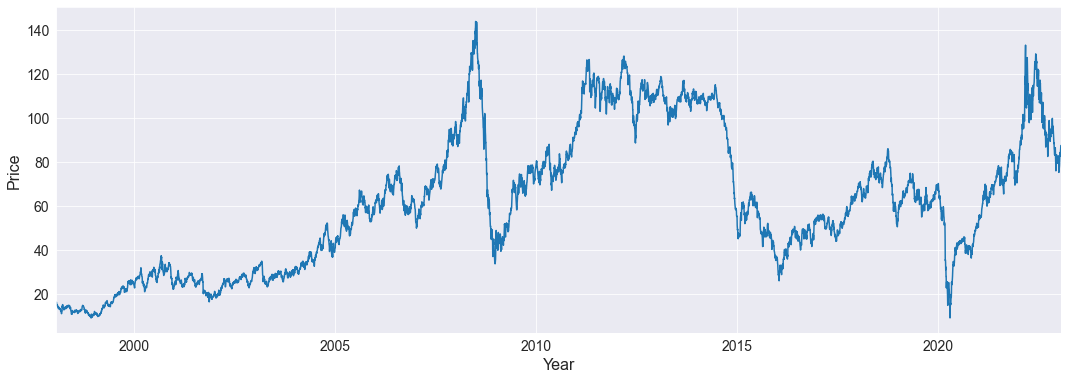

In [24]:
plt.figure(figsize=(18,6))
op_data.price.plot()
plt.xticks(rotation = 0,fontsize=14)
plt.yticks(rotation = 0,fontsize=14)
plt.xlabel("Year",fontsize=16)
plt.ylabel("Price",fontsize=16)
plt.show()

#### Observation:
+ From 1998 to 2006 the the oil price gradually increased without much fluctuations.
+ But from 2007 to 2008 the oil price increased very rapidly and later decreased more rapidly.
+ The oil price is constant from 2011 to 2013.
+ In 2014 it again decreased rapidly and is constant upto 2020.
+ In 2020 it rapidly decreased and later on it gradually increased upto 2022.


#### Box plot

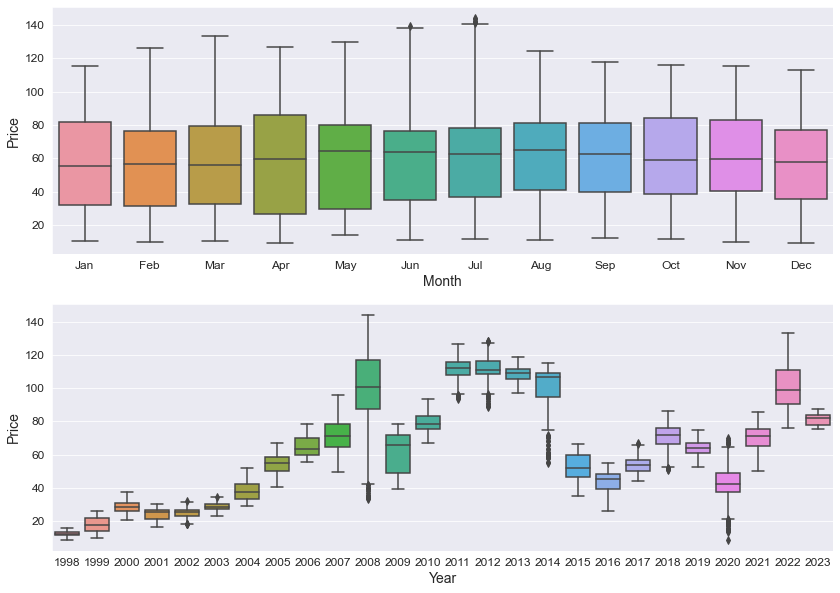

In [25]:
plt.figure(figsize=(14,10))
plt.subplot(211)
sb.boxplot(x='months', y='price', data=op_data_mdf)
plt.xticks(rotation = 0,fontsize=12)
plt.yticks(rotation = 0,fontsize=12)
plt.xlabel("Month",fontsize=14)
plt.ylabel("Price",fontsize=14)
plt.subplot(212)
sb.boxplot(x='year', y='price', data=op_data_mdf)
plt.xticks(rotation = 0,fontsize=12)
plt.yticks(rotation = 0,fontsize=12)
plt.xlabel("Year",fontsize=14)
plt.ylabel("Price",fontsize=14)
plt.show()

#### Observation:
+ We can see a huge fluctuation in the oil price in 2008.

#### Heat map

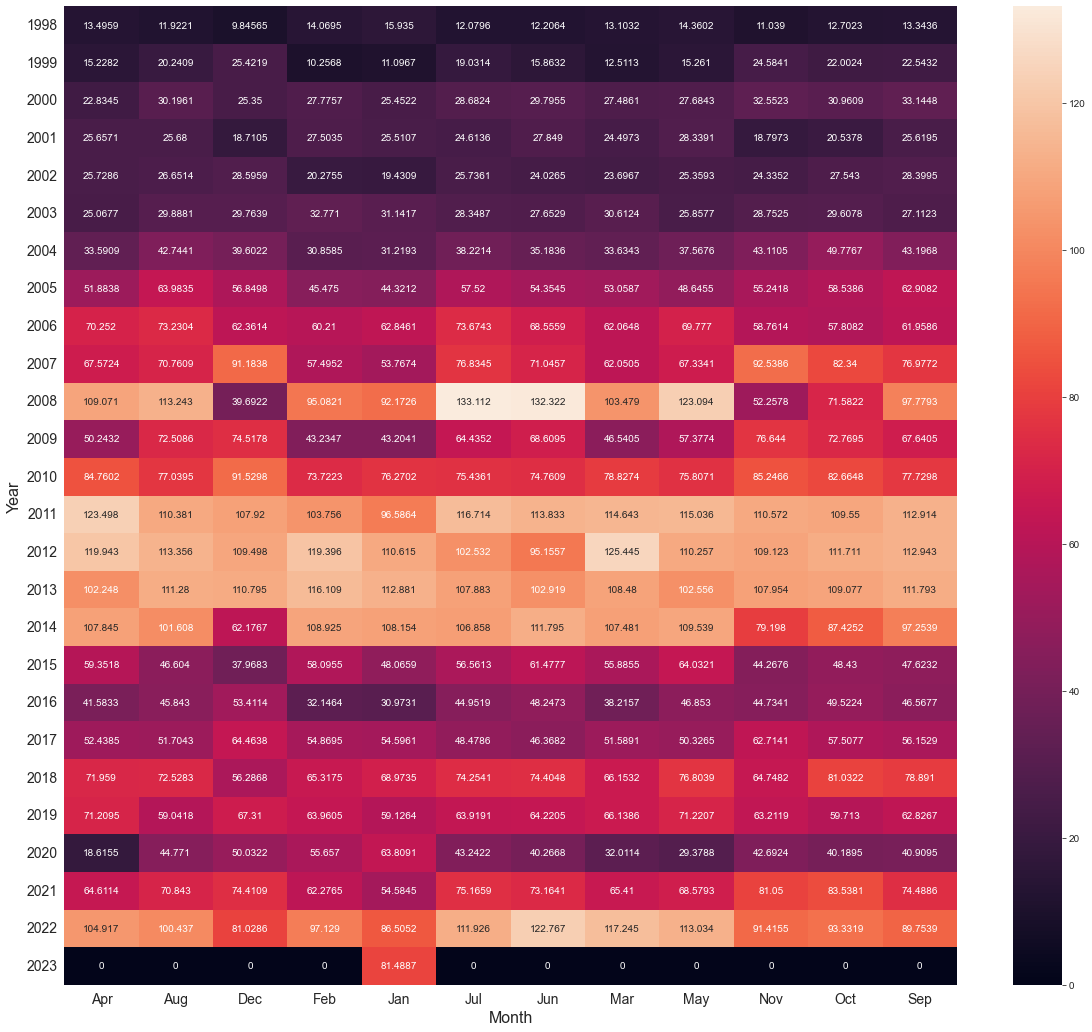

In [26]:
heatmap_price = pd.pivot_table(data=op_data_mdf,values='price',index='year',
                                    columns='months',aggfunc='mean',fill_value=0)
plt.figure(figsize=(20,18))
sb.heatmap(data =heatmap_price , annot=True,fmt='g')
plt.xticks(rotation = 0,fontsize=14)
plt.yticks(rotation = 0,fontsize=14)
plt.xlabel("Month",fontsize=16)
plt.ylabel("Year",fontsize=16)
plt.show()

#### Observation:
+ We can see the average oil price month-wise.
+ The maximum average oil price in month is 133.112, that is in July 2008.


#### Yearly price plot

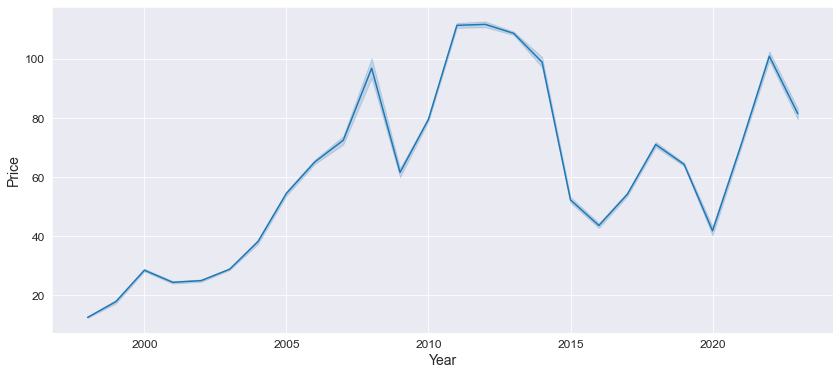

In [27]:
plt.figure(figsize=(14,6))
sb.lineplot(x='year',y='price',data=op_data_mdf)
plt.xticks(rotation = 0,fontsize=12)
plt.yticks(rotation = 0,fontsize=12)
plt.xlabel("Year",fontsize=14)
plt.ylabel("Price",fontsize=14)
plt.show()

#### Monthly price plot

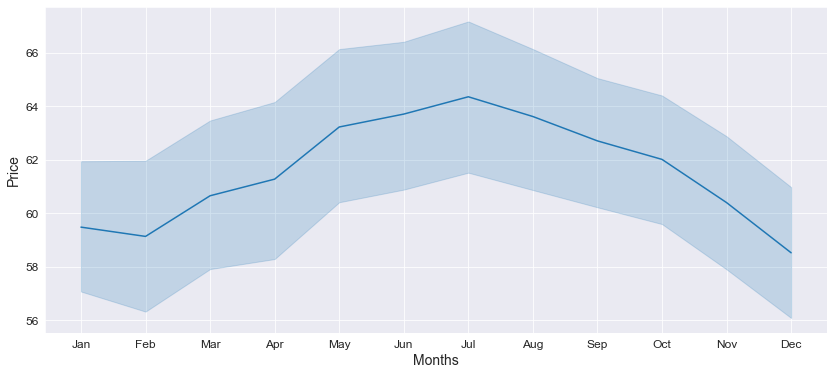

In [28]:
plt.figure(figsize=(14,6))
sb.lineplot(x='months',y='price',data=op_data_mdf)
plt.xticks(rotation = 0,fontsize=12)
plt.yticks(rotation = 0,fontsize=12)
plt.xlabel("Months",fontsize=14)
plt.ylabel("Price",fontsize=14)
plt.show()

#### Observation:
+ It is observed that oil prices increase in June, July and August.

#### Histogram

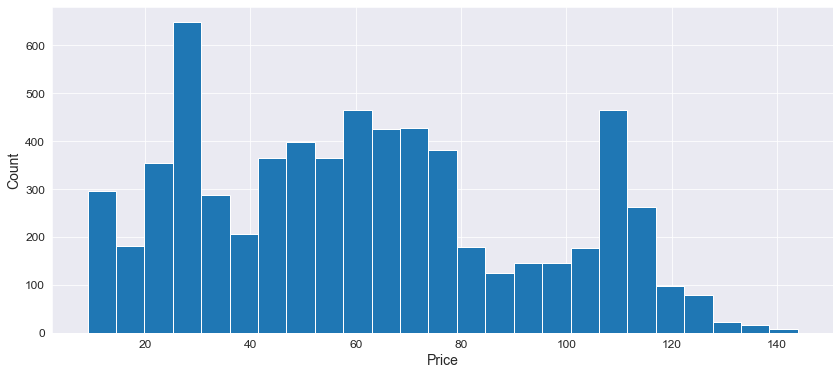

In [29]:
op_data_mdf.price.hist(figsize=(14,6),bins=25)
plt.xlabel("Price", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation = 0,fontsize=12)
plt.yticks(rotation = 0,fontsize=12)
plt.show()

#### Density plot

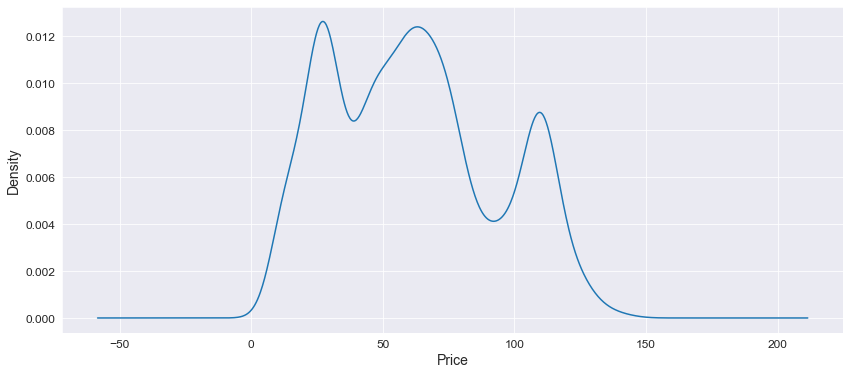

In [30]:
plt.figure(figsize=(14,6))
op_data.price.plot(kind='kde', figsize=(14,6))
plt.xlabel("Price", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(rotation = 0,fontsize=12)
plt.yticks(rotation = 0,fontsize=12)
plt.show()

#### Lag plot

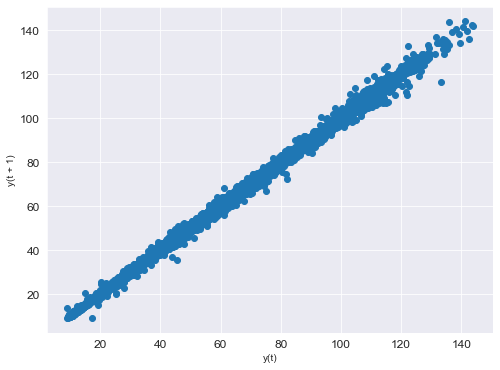

In [31]:
plt.figure(figsize=(8,6))
lag_plot(op_data.price)
plt.xticks(rotation = 0,fontsize=12)
plt.yticks(rotation = 0,fontsize=12)
plt.show()

#### Plotting Moving Average

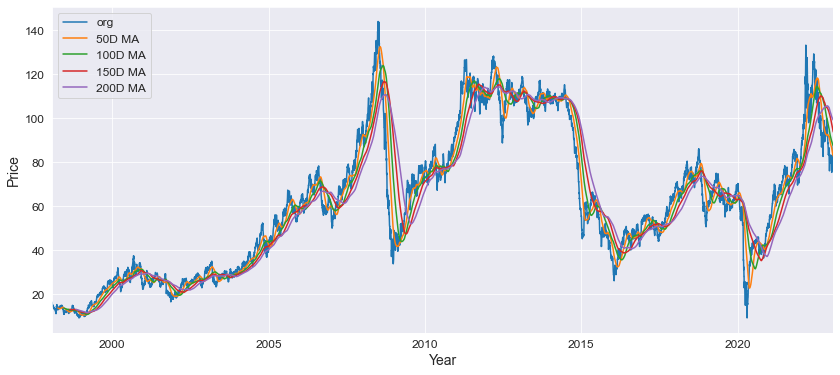

In [32]:
plt.figure(figsize=(14,6))
op_data.price.plot(x="year",label="org")
for i in range(50,250,50):
    op_data["price"].rolling(i).mean().plot(label=str(i)+"D MA")
plt.legend(loc='best', fontsize=12) 
plt.xlabel("Year",fontsize=14)
plt.ylabel("Price",fontsize=14)
plt.xticks(rotation = 0,fontsize=12)
plt.yticks(rotation = 0,fontsize=12)
plt.show()

#### Time series decomposition plot 

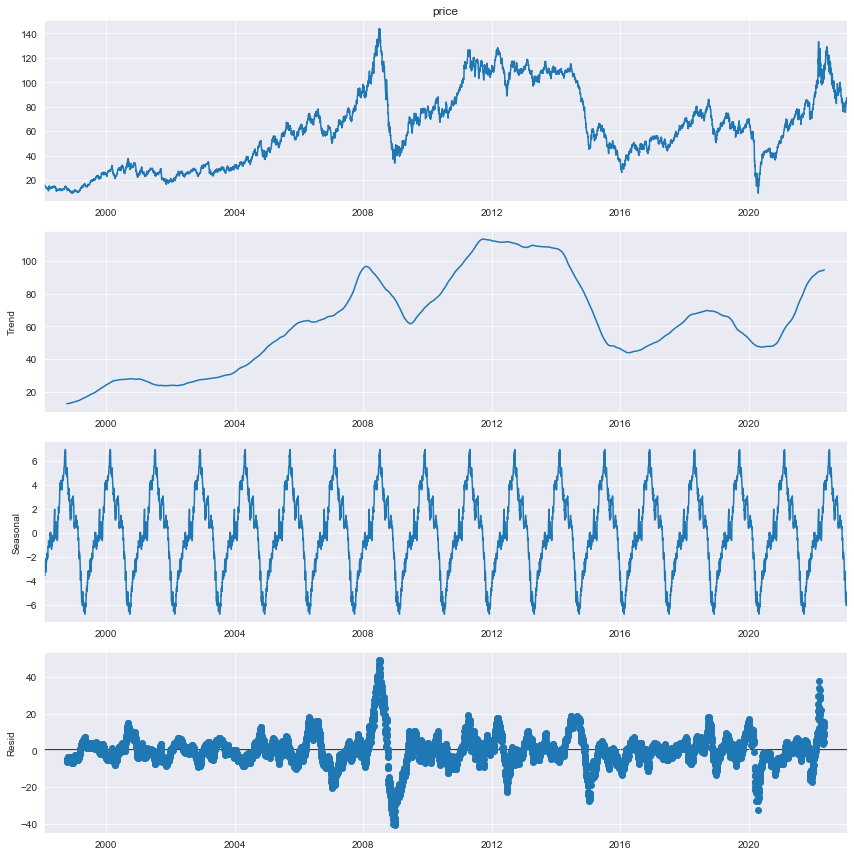

In [33]:
decompose_ts_add = seasonal_decompose(op_data.price,period=365)
with plt.rc_context():
    plt.rc("figure", figsize=(12,12))
    decompose_ts_add.plot()
    plt.show()

### ACF plots and PACF plots

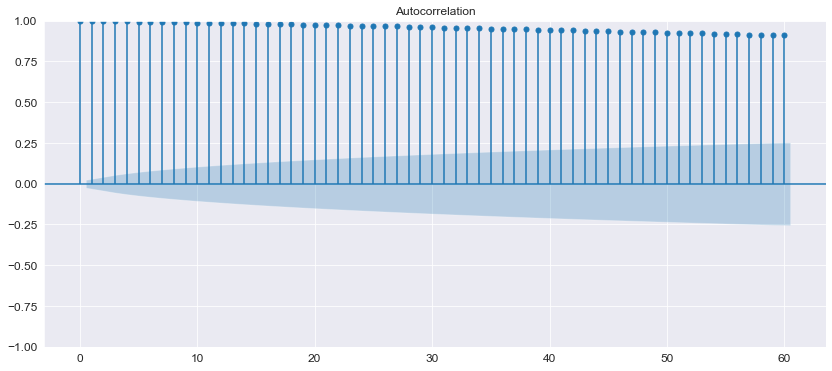

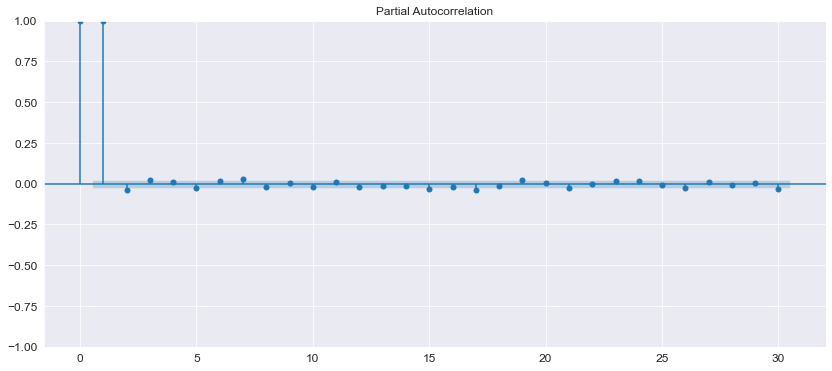

In [34]:
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_acf(op_data_mdf.price,lags=60)
    plt.xticks(rotation = 0,fontsize=12)
    plt.yticks(rotation = 0,fontsize=12)
    tsa_plots.plot_pacf(op_data_mdf.price,lags=30)
    plt.xticks(rotation = 0,fontsize=12)
    plt.yticks(rotation = 0,fontsize=12)
    plt.show()

### Step-5 : Test of Stationarity

##### As we have yearly data the window size for moving average is equal to 12

In [35]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(14,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['price'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### Augmented Dicky Fuller Test
Null Hypothesis (H0): The series is not stationary

p-val > 0.05

Alternate Hypothesis (H1): The series is stationary

p-val <= 0.05

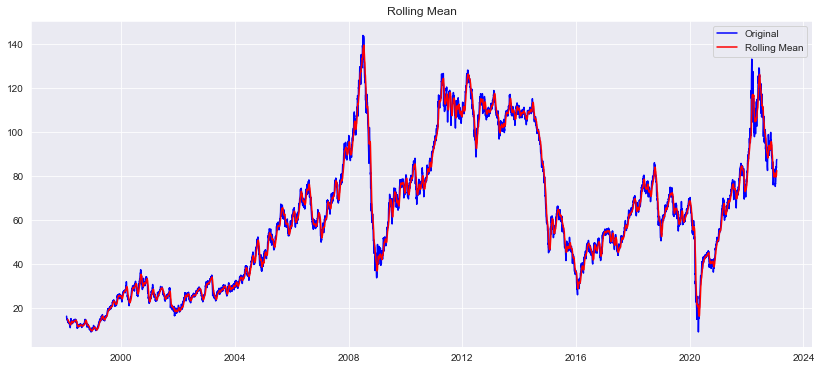

Results of Dickey Fuller Test:
Test Statistic                   -2.476286
p-value                           0.121351
#Lags Used                       32.000000
Number of Observations Used    6485.000000
Critical Value (1%)              -3.431359
Critical Value (5%)              -2.861986
Critical Value (10%)             -2.567007
dtype: float64


In [36]:
price= pd.DataFrame()
price['price'] = op_data[['price']]
test_stationarity(price)

In [37]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [38]:
adf_test(price)

Fail to reject the null hypothesis
Data is non-stationary


### Step-6 : Feature Scaling (Transformations)

#### Square Root Transform

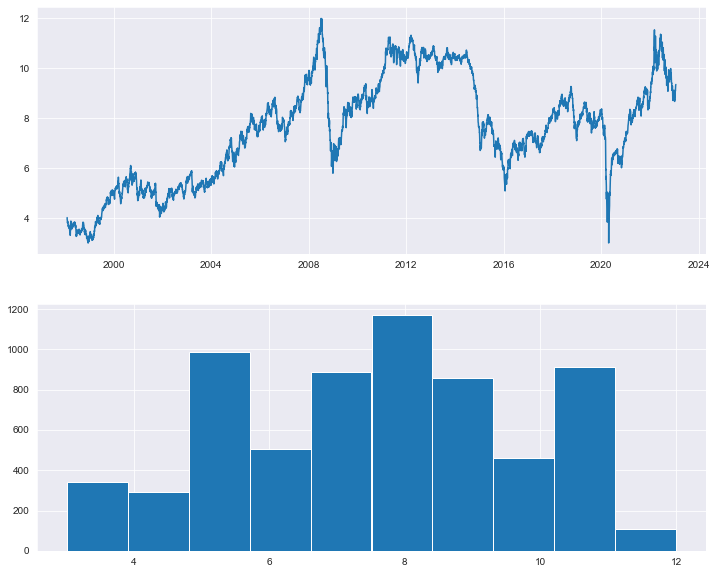

In [39]:
square_root= pd.DataFrame()
square_root = op_data[['price']]
square_root['price'] = np.sqrt(square_root.price)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['price'])
#Histogram
plt.subplot(212)
plt.hist(square_root['price'])
plt.show()

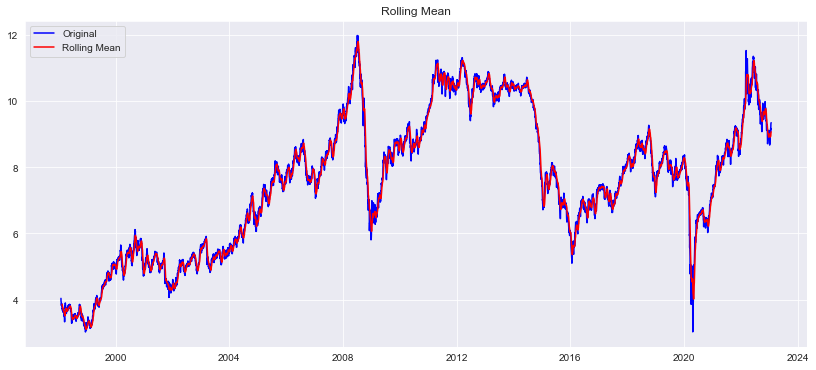

Results of Dickey Fuller Test:
Test Statistic                   -2.312969
p-value                           0.167819
#Lags Used                       20.000000
Number of Observations Used    6497.000000
Critical Value (1%)              -3.431357
Critical Value (5%)              -2.861985
Critical Value (10%)             -2.567007
dtype: float64


In [40]:
test_stationarity(square_root)

In [41]:
adf_test(square_root)

Fail to reject the null hypothesis
Data is non-stationary


#### Log Transform

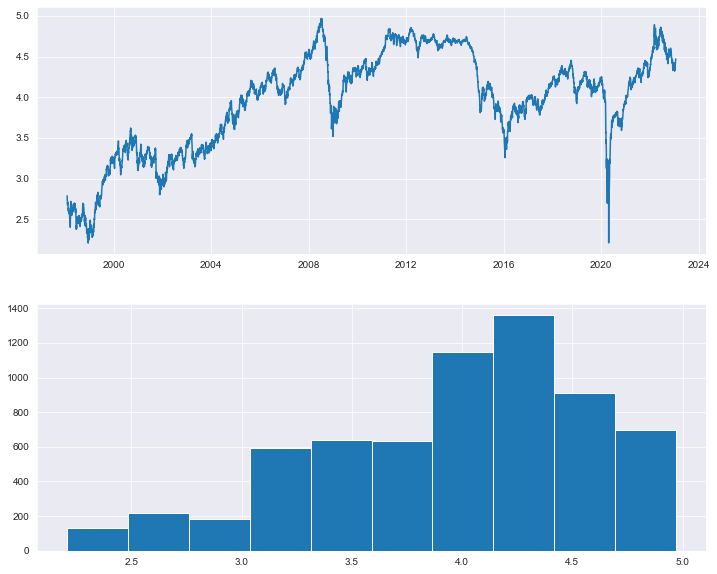

In [42]:
log = pd.DataFrame()
log = op_data[['price']]
log['price'] = np.log(log.price)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['price'])
#Histogram
plt.subplot(212)
plt.hist(log['price'])
plt.show()

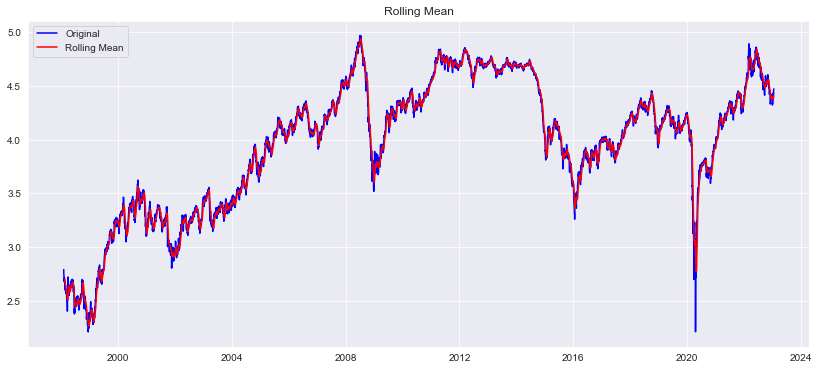

Results of Dickey Fuller Test:
Test Statistic                   -2.545704
p-value                           0.104746
#Lags Used                       35.000000
Number of Observations Used    6482.000000
Critical Value (1%)              -3.431359
Critical Value (5%)              -2.861986
Critical Value (10%)             -2.567007
dtype: float64


In [43]:
test_stationarity(log)

In [44]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


#### Box Cox Transformation

,price
date,
1998-01-29,2.789937
1998-01-30,2.746630
1998-02-02,2.726545
1998-02-03,2.699346
1998-02-04,2.678278


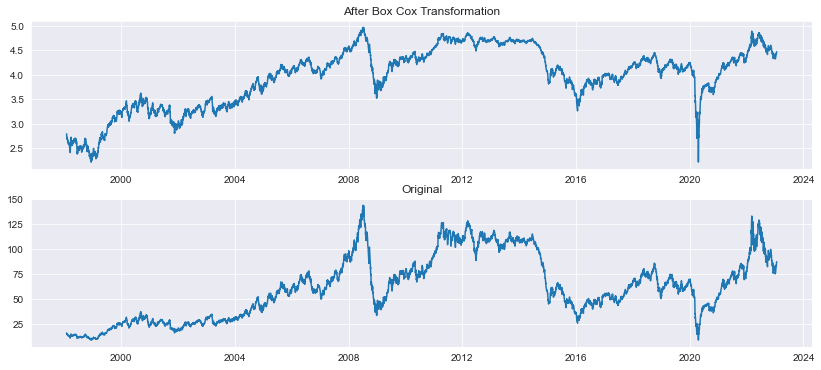

In [45]:
data_boxcox = pd.DataFrame()
data_boxcox['price'] = pd.Series(boxcox(op_data['price'], lmbda=0), op_data.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(op_data, label='original')
axis[1].set_title('Original')
plt.show()

#### Observation
1. We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar.
2. But we can see that still the series has an upward trend. The mean is not zero.

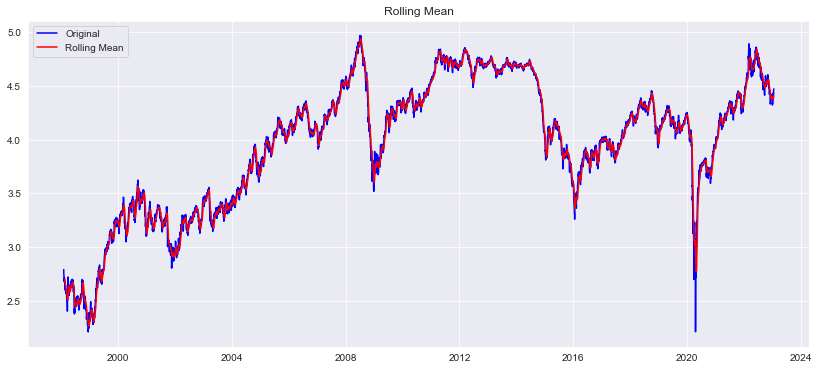

Results of Dickey Fuller Test:
Test Statistic                   -2.545704
p-value                           0.104746
#Lags Used                       35.000000
Number of Observations Used    6482.000000
Critical Value (1%)              -3.431359
Critical Value (5%)              -2.861986
Critical Value (10%)             -2.567007
dtype: float64


In [46]:
test_stationarity(data_boxcox)

In [47]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


##### Hence, the Time series data is Non-Stationary

### Step-7 :  Converting Non-Stationary Time Series into Stationary

#### Differencing
In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

yt‘ = yt – y(t-1)

where yt is the value at a time t

Applying differencing on our series and plotting the results:

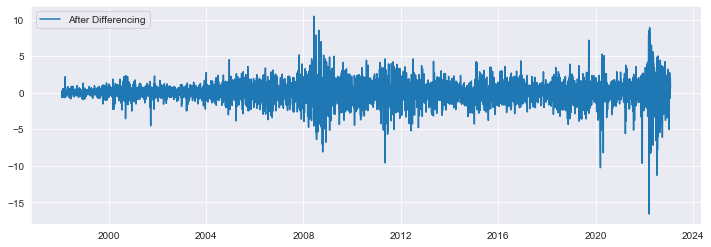

In [48]:
differencing = op_data - op_data.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

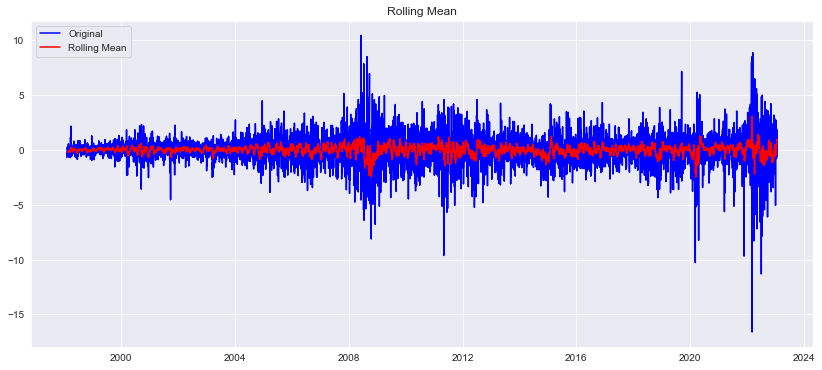

Results of Dickey Fuller Test:
Test Statistic                -1.235795e+01
p-value                        5.630464e-23
#Lags Used                     3.500000e+01
Number of Observations Used    6.481000e+03
Critical Value (1%)           -3.431359e+00
Critical Value (5%)           -2.861986e+00
Critical Value (10%)          -2.567007e+00
dtype: float64


In [49]:
test_stationarity(differencing)

In [50]:
adf_test(differencing)

Reject the null hypothesis
Data is stationary


#### Seasonal Differencing
In seasonal differencing, instead of calculating the difference between consecutive values, we calculate the difference between an observation and a previous observation from the same season. For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday. Mathematically it can be written as:

yt‘ = yt – y(t-n)

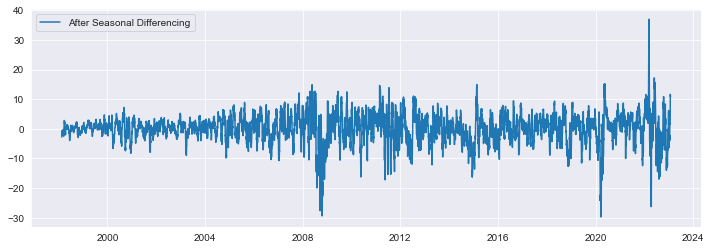

In [51]:
seasonal_differencing = op_data - op_data.shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

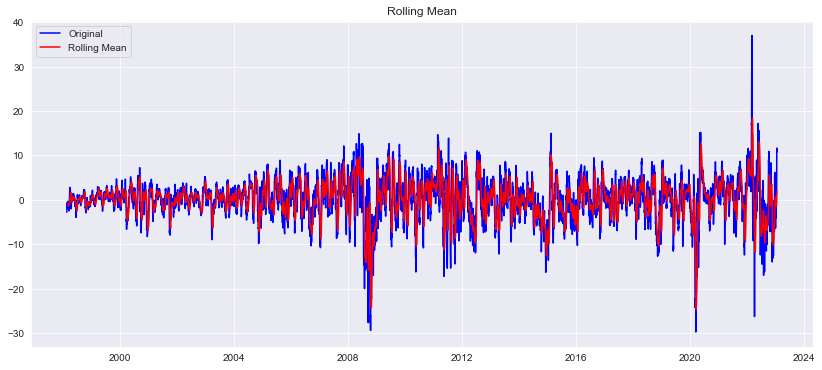

Results of Dickey Fuller Test:
Test Statistic                -1.205969e+01
p-value                        2.486022e-22
#Lags Used                     3.300000e+01
Number of Observations Used    6.472000e+03
Critical Value (1%)           -3.431361e+00
Critical Value (5%)           -2.861987e+00
Critical Value (10%)          -2.567008e+00
dtype: float64


In [52]:
test_stationarity(seasonal_differencing)

In [53]:
adf_test(seasonal_differencing)

Reject the null hypothesis
Data is stationary


#### Differencing of the Log Transformation
Differencing is performed by subtracting the previous observation from the current observation.

Differencing removes trend and seasonality in a Time series. When an entire cycle is used for differencing the other cycle, then the seasonality is removed.

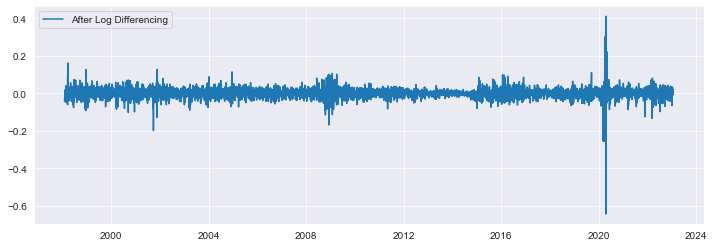

In [54]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

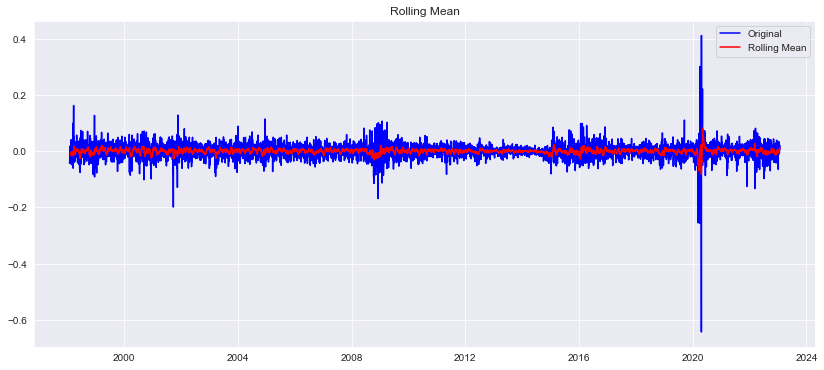

Results of Dickey Fuller Test:
Test Statistic                -1.408523e+01
p-value                        2.783004e-26
#Lags Used                     3.500000e+01
Number of Observations Used    6.481000e+03
Critical Value (1%)           -3.431359e+00
Critical Value (5%)           -2.861986e+00
Critical Value (10%)          -2.567007e+00
dtype: float64


In [55]:
test_stationarity(log_diff)

In [56]:
adf_test(log_diff)

Reject the null hypothesis
Data is stationary


In [57]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


#### Differencing of the Box-Cox Transformation
Differencing is performed by subtracting the previous observation from the current observation.

Differencing removes trend and seasonality in a Time series. When an entire cycle is used for differencing the other cycle, then the seasonality is removed.

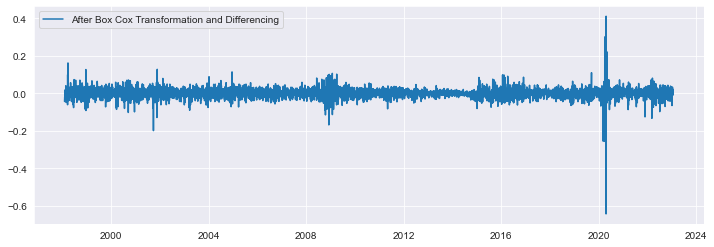

In [58]:
# data_boxcox - data_boxcox.shift() :- Performs difference between the previous and current observations.
#data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation. 
2. It is a horizontal trend.
3. The mean is zero.
4. Also, the variance is almost constant.

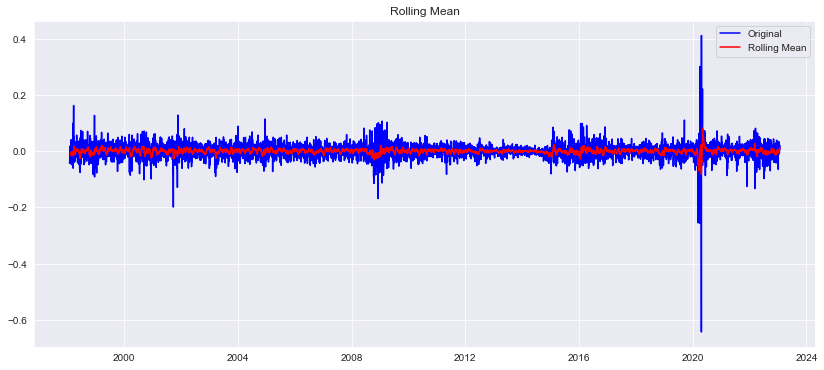

Results of Dickey Fuller Test:
Test Statistic                -1.408523e+01
p-value                        2.783004e-26
#Lags Used                     3.500000e+01
Number of Observations Used    6.481000e+03
Critical Value (1%)           -3.431359e+00
Critical Value (5%)           -2.861986e+00
Critical Value (10%)          -2.567007e+00
dtype: float64


In [59]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

In [60]:
adf_test(data_boxcox_diff)

Reject the null hypothesis
Data is stationary


### Step-8 : Split the data into training and testing data

In [61]:
x_train = op_data_mdf.head(5215)
x_test  = op_data_mdf.tail(1303)
print(x_train.shape)
print(x_test.shape)

(5215, 20)
(1303, 20)


### Step-9 : Build different models for Forecasting

### Step-9.1 : Data-Driven Techniques

#### Evaluation Metric MAPE

In [62]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

#### Simple Exponential Method

In [63]:
model_ses = SimpleExpSmoothing(x_train["price"]).fit(smoothing_level=0.2)
pred_ses = model_ses.predict(start = x_test.index[0],end = x_test.index[-1])
mape_ses = np.round(MAPE(pred_ses,x_test.price),2)  
rmse_ses = np.round(np.sqrt(mean_squared_error(pred_ses,x_test.price)),2)
print("Root Mean Square Error : ",rmse_ses)

Root Mean Square Error :  21.25


#### Holt's Method (Double Exponential Method)

In [64]:
model_h = Holt(x_train["price"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_h = model_h.predict(start = x_test.index[0],end = x_test.index[-1])
mape_h = np.round(MAPE(pred_h,x_test.price),2)
rmse_h = np.round(np.sqrt(mean_squared_error(pred_h,x_test.price)),2)
print("Root Mean Square Error : ",rmse_h)

Root Mean Square Error :  90.4


#### Holt-Winter's Exponential Smoothing with Additive Seasonality and Trend (Triple Exponential Method)

In [65]:
model_hw_as_at = ExponentialSmoothing(x_train["price"],seasonal="add",trend="add",
                                      seasonal_periods=12).fit(optimized=True)
pred_hw_as_at = model_hw_as_at.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_as_at = np.round(MAPE(pred_hw_as_at,x_test.price),2)
rmse_hw_as_at = np.round(np.sqrt(mean_squared_error(pred_hw_as_at,x_test.price)),2)
print("Root Mean Square Error : ",rmse_hw_as_at)

Root Mean Square Error :  20.91


#### Holt-Winter's Exponential Smoothing with Multiplicative Seasonality and Additive Trend (Triple Exponential Method)

In [66]:
model_hw_ms_at = ExponentialSmoothing(x_train["price"],seasonal="mul",trend="add",
                                      seasonal_periods=12).fit(optimized=True)
pred_hw_ms_at = model_hw_ms_at.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_ms_at = np.round(MAPE(pred_hw_ms_at,x_test.price),2)
rmse_hw_ms_at = np.round(np.sqrt(mean_squared_error(pred_hw_ms_at,x_test.price)),2)
print("Root Mean Square Error : ",rmse_hw_ms_at)

Root Mean Square Error :  20.9


#### Holt-Winter's Exponential Smoothing with Additive Seasonality and Multiplicative Trend (Triple Exponential Method)

In [67]:
model_hw_as_mt = ExponentialSmoothing(x_train["price"],seasonal="add",trend="mul",
                                      seasonal_periods=12).fit(optimized=True)
pred_hw_as_mt = model_hw_as_mt.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_as_mt = np.round(MAPE(pred_hw_as_mt,x_test.price),2)
rmse_hw_as_mt =np.round(np.sqrt(mean_squared_error(pred_hw_as_mt,x_test.price)),2)
print("Root Mean Square Error : ",rmse_hw_as_mt)

Root Mean Square Error :  22.21


#### Holt-Winter's Exponential Smoothing with Multiplicative Seasonality and Multiplicative Trend (Triple Exponential Method)

In [68]:
model_hw_ms_mt = ExponentialSmoothing(x_train["price"],seasonal="mul",trend="mul",
                                      seasonal_periods=12).fit(optimized=True)
pred_hw_ms_mt = model_hw_ms_mt.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_ms_mt = np.round(MAPE(pred_hw_ms_mt,x_test.price),2)
rmse_hw_ms_mt = np.round(np.sqrt(mean_squared_error(pred_hw_ms_mt,x_test.price)),2)
print("Root Mean Square Error : ",rmse_hw_ms_mt)

Root Mean Square Error :  23.7


#### Auto-Regressive Integrated Moving Average (ARIMA)

In [73]:
x_train = data_boxcox_diff.head(5215)
x_test  = data_boxcox_diff.tail(1303)
print(x_train.shape)
print(x_test.shape)

(5215, 1)
(1303, 1)


In [74]:
from pmdarima import auto_arima
stepwise_model = auto_arima(x_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=41.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-17407.633, Time=5.71 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-20511.782, Time=13.86 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=36.53 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-18859.066, Time=2.64 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-21040.821, Time=27.79 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=65.87 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=32.43 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-19617.762, Time=26.13 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-21669.860, Time=19.72 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-21135.512, Time=16.02 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=74.85 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=37.47 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-21972.895, Time=27.15 sec
 ARIMA(3,1,0)(1,1,0)[

In [76]:
# fit model
model_arima = ARIMA(x_train, order=(3,1,0)).fit()
pred_arima = model_arima.predict(start = x_test.index[0],end = x_test.index[-1])
mape_arima = np.round(MAPE(pred_arima.values,x_test.price.values),2)
rmse_arima = np.round(np.sqrt(mean_squared_error(pred_arima,x_test.price)),2)
print("Root Mean Square Error : ",rmse_arima)

Root Mean Square Error :  0.04


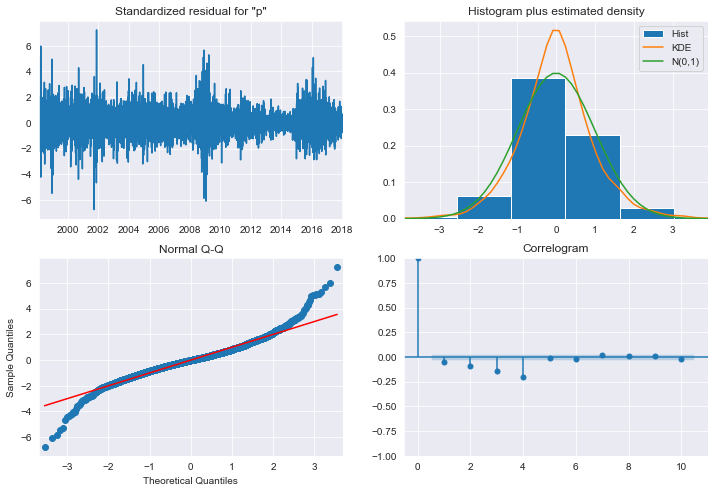

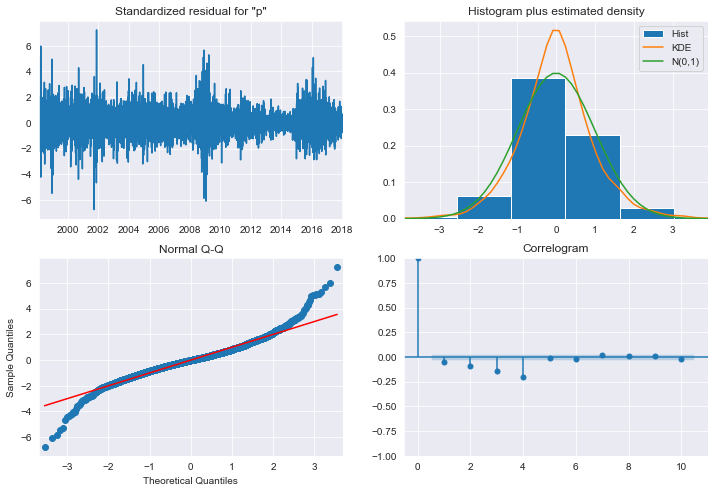

In [77]:
model_arima.plot_diagnostics(figsize=(12,8)) 

#### Neural Networks - Long Short Term Model (LSTM)

In [78]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [79]:
dataset = op_data.price.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 100
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [80]:
X_test.shape

(1203, 1, 100)

In [81]:
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt

In [83]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, Y_train, epochs=50, batch_size=50, validation_data=(X_test, Y_test), 
                   callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/50
103/103 [==============================] - 19s 35ms/step - loss: 0.0146 - val_loss: 0.0219
Epoch 2/50
103/103 [==============================] - 1s 9ms/step - loss: 0.0086 - val_loss: 0.0219
Epoch 3/50
103/103 [==============================] - 1s 10ms/step - loss: 0.0075 - val_loss: 0.0219
Epoch 4/50
103/103 [==============================] - 1s 9ms/step - loss: 0.0074 - val_loss: 0.0172
Epoch 5/50
103/103 [==============================] - 1s 10ms/step - loss: 0.0060 - val_loss: 0.0128
Epoch 6/50
103/103 [==============================] - 1s 12ms/step - loss: 0.0049 - val_loss: 0.0084
Epoch 7/50
103/103 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 8/50
103/103 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 9/50
103/103 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 10/50
103/103 [==============================] - 1s 10ms/step - loss: 0.0024 - val_los

In [84]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

38/38 [==============================] - 0s 5ms/step
Train Mean Absolute Error: 2.457348513665241
Train Root Mean Squared Error: 3.3481018230850643
Test Mean Absolute Error: 3.229142164954775
Test Root Mean Squared Error: 4.450078042123954


In [85]:
rmse_lstm = np.round(np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])),2)

In [86]:
test_predict.shape

(1203, 1)

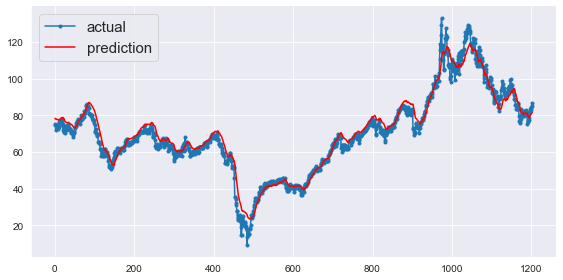

In [87]:
aa=[x for x in range(1203)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:1203], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:1203], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sb.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend(fontsize=15)
plt.show();

In [88]:
from sklearn.metrics import r2_score
r2_score(Y_train[0],train_predict[:,0])

0.9896796455708748

In [89]:
r2_score(Y_test[0], test_predict[:,0])


0.9592917523512865

### Step-9.1.1 : Comparing the results

In [90]:
pd.set_option('max_colwidth',100)

In [91]:
model_list                = ["SES Method","Holt's Method",
                             "H-W's Exp. Smooothing with Add. Seasonality and Trend",
                             "H-W's Exp. Smoothing with Mul. Seasonality and Add. Trend",
                             "H-W's Exp. Smoothing with Add. Seasonality and Mul. Trend",
                             "H-W's Exp. Smoothing with Mul. Seasonality and Mul. Trend",
                             "ARIMA", "LSTM"
                            ]
rmse_val_list             = [rmse_ses,rmse_h,rmse_hw_as_at,rmse_hw_ms_at,rmse_hw_as_mt,rmse_hw_ms_mt
                             ,rmse_arima,rmse_lstm]

table_rmse                = pd.DataFrame(columns=['Model','RMSE_Values'])
table_rmse['Model']       = model_list
table_rmse['RMSE_Values'] = rmse_val_list
table_rmse

,Model,RMSE_Values
0,SES Method,21.25
1,Holt's Method,90.40
2,H-W's Exp. Smooothing with Add. Seasonality and Trend,20.91
3,H-W's Exp. Smoothing with Mul. Seasonality and Add. Trend,20.90
4,H-W's Exp. Smoothing with Add. Seasonality and Mul. Trend,22.21
5,H-W's Exp. Smoothing with Mul. Seasonality and Mul. Trend,23.70
6,ARIMA,0.04
7,LSTM,3.35


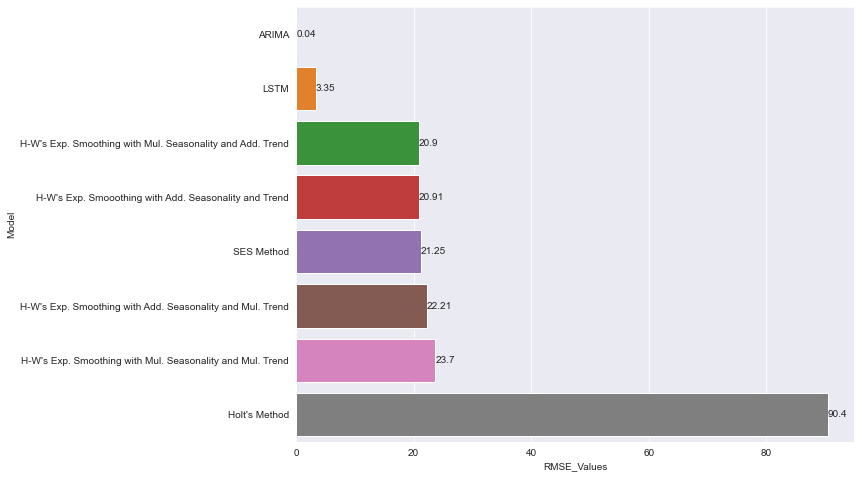

In [92]:
plt.figure(figsize=(10,8))
ax = sb.barplot(x='RMSE_Values',y='Model',data=table_rmse,order=table_rmse.sort_values('RMSE_Values').Model)
for i in ax.containers:
    ax.bar_label(i)

### Step-9.2 : Model Driven Techniques

In [93]:
x_train = op_data_mdf.head(5215)
x_test  = op_data_mdf.tail(1303)
print(x_train.shape)
print(x_test.shape)

(5215, 20)
(1303, 20)


#### Linear Model

In [94]:
model_lin     = smf.ols('price~t',data=x_train).fit()
predicted_lin = pd.Series(model_lin.predict(pd.DataFrame(x_test['t'])))
rmse_lin      = np.sqrt(np.mean(np.array(x_test['price'])-np.array(predicted_lin))**2)
rmse_lin      = round(rmse_lin,2)
print("Root Mean Square Error : ",rmse_lin)

Root Mean Square Error :  34.86


#### Exponential Model

In [95]:
model_exp = smf.ols('log_price~t',data=x_train).fit()
pred_exp  = pd.Series(model_exp.predict(pd.DataFrame(x_test['t'])))
rmse_exp  = np.sqrt(np.mean((np.array(x_test['log_price'])-np.array(np.exp(pred_exp)))**2))
rmse_exp  = round(rmse_exp,2)
print("Root Mean Square Error : ",rmse_exp)

Root Mean Square Error :  132.92


#### Quadratic 

In [96]:
model_quad = smf.ols('price~t+t_square',data=x_train).fit()
pred_quad = pd.Series(model_quad.predict(x_test[["t","t_square"]]))
rmse_quad = np.sqrt(np.mean((np.array(x_test['price'])-np.array(pred_quad))**2))
rmse_quad = round(rmse_quad,2)
print("Root Mean Square Error : ",rmse_quad)

Root Mean Square Error :  44.08


#### Additive seasonality 

In [97]:
model_add_sea = smf.ols('price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=x_train).fit()
pred_add_sea = pd.Series(model_add_sea.predict(x_test[['Jan','Feb','Mar','Apr','May','Jun','Jul',
                                               'Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(x_test['price'])-np.array(pred_add_sea))**2))
rmse_add_sea = round(rmse_add_sea,2)
print("Root Mean Square Error : ",rmse_add_sea)

Root Mean Square Error :  23.58


#### Additive Seasonality Quadratic 

In [98]:
model_add_sea_quad = smf.ols('price~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=x_train).fit()
pred_add_sea_quad = pd.Series(model_add_sea_quad.predict(x_test[['Jan','Feb','Mar','Apr','May','Jun','Jul',
                                               'Aug','Sep','Oct','Nov','Dec','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(x_test['price'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad = round(rmse_add_sea_quad,2)
print("Root Mean Square Error : ",rmse_add_sea_quad)

Root Mean Square Error :  44.03


#### Multiplicative Seasonality

In [99]:
model_mul_sea = smf.ols('log_price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',
                  data = x_train).fit()
pred_mul_sea = pd.Series(model_mul_sea.predict(x_test))
rmse_mul_sea = np.sqrt(np.mean((np.array(x_test['price'])-np.array(np.exp(pred_mul_sea)))**2))
rmse_mul_sea = round(rmse_mul_sea,2)
print("Root Mean Square Error : ",rmse_mul_sea)

Root Mean Square Error :  29.4


#### Multiplicative Additive Seasonality 

In [100]:
model_mul_add_sea = smf.ols('log_price~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = x_train).fit()
pred_mul_add_sea = pd.Series(model_mul_add_sea.predict(x_test))
rmse_mul_add_sea = np.sqrt(np.mean((np.array(x_test['price'])-np.array(np.exp(pred_mul_add_sea)))**2))
rmse_mul_add_sea = round(rmse_mul_add_sea,2)
print("Root Mean Square Error : ",rmse_mul_add_sea)

Root Mean Square Error :  69.4


### Step-9.2.1 : Comparing the results

In [101]:
model_list                = ["Linear","Exponential","Quadratic","Additive Seasonality",
                             "Additive Seasonality Quadratic","Multiplicative Seasonality",
                             "Multiplicative Additive Seasonality"]
rmse_val_list             = [rmse_lin,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mul_sea,
                                 rmse_mul_add_sea]

table_rmse                = pd.DataFrame(columns=['Model','RMSE_Values'])
table_rmse['Model']       = model_list
table_rmse['RMSE_Values'] = rmse_val_list

table_rmse

,Model,RMSE_Values
0,Linear,34.86
1,Exponential,132.92
2,Quadratic,44.08
3,Additive Seasonality,23.58
4,Additive Seasonality Quadratic,44.03
5,Multiplicative Seasonality,29.40
6,Multiplicative Additive Seasonality,69.40


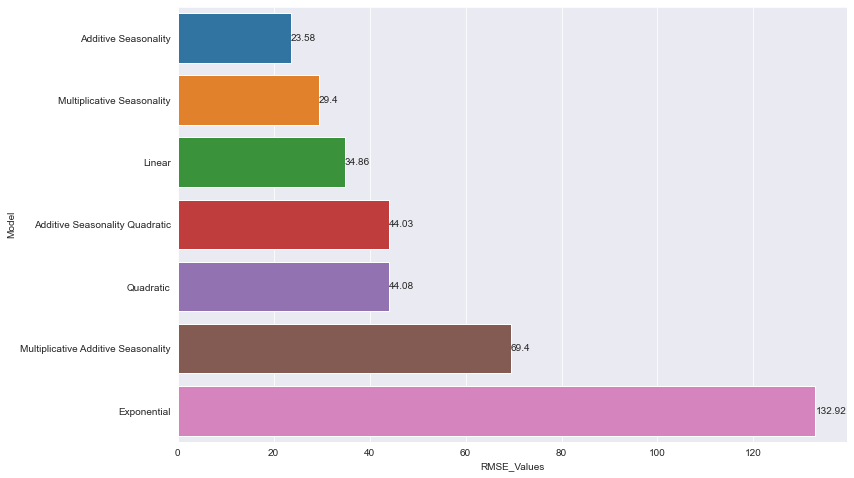

In [102]:
plt.figure(figsize=(12,8))
ax = sb.barplot(x='RMSE_Values',y='Model',data=table_rmse,order=table_rmse.sort_values('RMSE_Values').Model)
for i in ax.containers:
    ax.bar_label(i)

### Step-10 : Predict for new time period

#### Out of all the models, ARIMA gave the lowest error. Hence use this model for forecasting.

In [221]:
new_data = op_data.tail(1303)
new_data

,price
date,
2018-01-25,71.08
2018-01-26,70.08
2018-01-29,68.41
2018-01-30,67.78
2018-01-31,67.78
...,...
2023-01-17,84.38
2023-01-18,83.78
2023-01-19,85.08


In [222]:
x_train = data_boxcox_diff.head(5215)
x_test  = data_boxcox_diff.tail(1303)
print(x_train.shape)
print(x_test.shape)

(5215, 1)
(1303, 1)


In [223]:
#picked the model with the lowest RMSE value
#training the model on the entire dataset
final_model = ARIMA(op_data["price"], order=(3,1,0)).fit()

In [224]:
op_data["price"]

date
1998-01-29    16.28
1998-01-30    15.59
1998-02-02    15.28
1998-02-03    14.87
1998-02-04    14.56
              ...  
2023-01-17    84.38
2023-01-18    83.78
2023-01-19    85.08
2023-01-20    86.96
2023-01-23    87.54
Name: price, Length: 6518, dtype: float64

In [225]:
op_data1 = op_data.head(5215)
print(op_data1.shape)
op_data1

(5215, 1)


,price
date,
1998-01-29,16.28
1998-01-30,15.59
1998-02-02,15.28
1998-02-03,14.87
1998-02-04,14.56
...,...
2018-01-18,69.48
2018-01-19,68.56
2018-01-22,69.32


In [226]:
predicted_new = final_model.predict(start = new_data.index[0],end = x_test.index[-1])
predicted_new

2018-01-25    69.895266
2018-01-26    71.121868
2018-01-29    70.010732
2018-01-30    68.349665
2018-01-31    67.801279
                ...    
2023-01-17    82.582813
2023-01-18    84.461395
2023-01-19    83.724354
2023-01-20    85.129892
2023-01-23    87.016475
Freq: B, Name: predicted_mean, Length: 1303, dtype: float64

In [227]:
new_data['forecasted_price'] = predicted_new
new_data

,price,forecasted_price
date,,
2018-01-25,71.08,69.895266
2018-01-26,70.08,71.121868
2018-01-29,68.41,70.010732
2018-01-30,67.78,68.349665
2018-01-31,67.78,67.801279
...,...,...
2023-01-17,84.38,82.582813
2023-01-18,83.78,84.461395
2023-01-19,85.08,83.724354


<AxesSubplot:xlabel='date'>

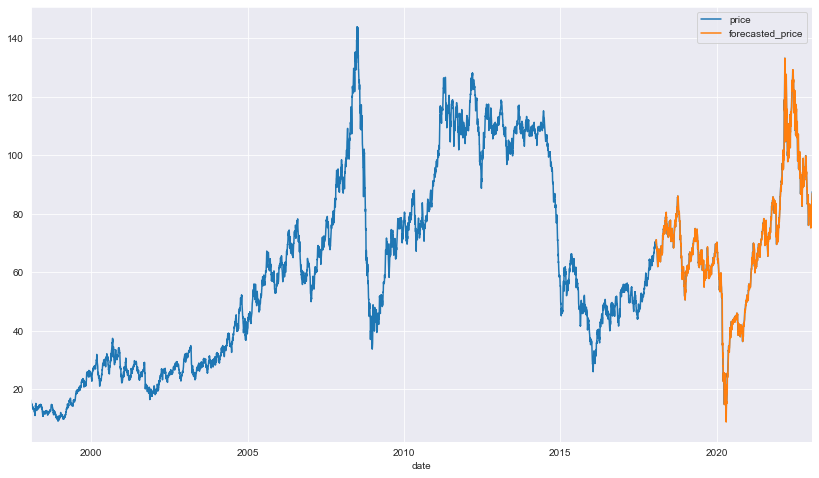

In [228]:
new_var = pd.concat([op_data1,new_data])
new_var[['price','forecasted_price']].plot(figsize=(14,8))

### Step-11 : Predict for future time period

In [229]:
## from datetime import datetime
start = datetime(2023, 1, 24)
end = datetime(2023, 2, 24)
future = pd.date_range(start, end)
future

DatetimeIndex(['2023-01-24', '2023-01-25', '2023-01-26', '2023-01-27',
               '2023-01-28', '2023-01-29', '2023-01-30', '2023-01-31',
               '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-04',
               '2023-02-05', '2023-02-06', '2023-02-07', '2023-02-08',
               '2023-02-09', '2023-02-10', '2023-02-11', '2023-02-12',
               '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
               '2023-02-17', '2023-02-18', '2023-02-19', '2023-02-20',
               '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24'],
              dtype='datetime64[ns]', freq='D')

In [230]:
predicted_future = final_model.predict(start = future[0], end = future[-1])
predicted_future

2023-01-24    87.508767
2023-01-25    87.474694
2023-01-26    87.467842
2023-01-27    87.468643
2023-01-30    87.469189
2023-01-31    87.469266
2023-02-01    87.469249
2023-02-02    87.469241
2023-02-03    87.469240
2023-02-06    87.469240
2023-02-07    87.469240
2023-02-08    87.469240
2023-02-09    87.469240
2023-02-10    87.469240
2023-02-13    87.469240
2023-02-14    87.469240
2023-02-15    87.469240
2023-02-16    87.469240
2023-02-17    87.469240
2023-02-20    87.469240
2023-02-21    87.469240
2023-02-22    87.469240
2023-02-23    87.469240
2023-02-24    87.469240
Freq: B, Name: predicted_mean, dtype: float64

In [231]:
new_future = pd.DataFrame(predicted_future)
new_future.columns =['forecasted_price']

In [232]:
new_future

,forecasted_price
2023-01-24,87.508767
2023-01-25,87.474694
2023-01-26,87.467842
2023-01-27,87.468643
2023-01-30,87.469189
2023-01-31,87.469266
2023-02-01,87.469249
2023-02-02,87.469241
2023-02-03,87.469240
2023-02-06,87.469240


In [233]:
new_combine = pd.concat([op_data,new_future],axis=0)
new_combine

,price,forecasted_price
1998-01-29,16.28,NaN
1998-01-30,15.59,NaN
1998-02-02,15.28,NaN
1998-02-03,14.87,NaN
1998-02-04,14.56,NaN
...,...,...
2023-02-20,NaN,87.46924
2023-02-21,NaN,87.46924
2023-02-22,NaN,87.46924
2023-02-23,NaN,87.46924


<AxesSubplot:>

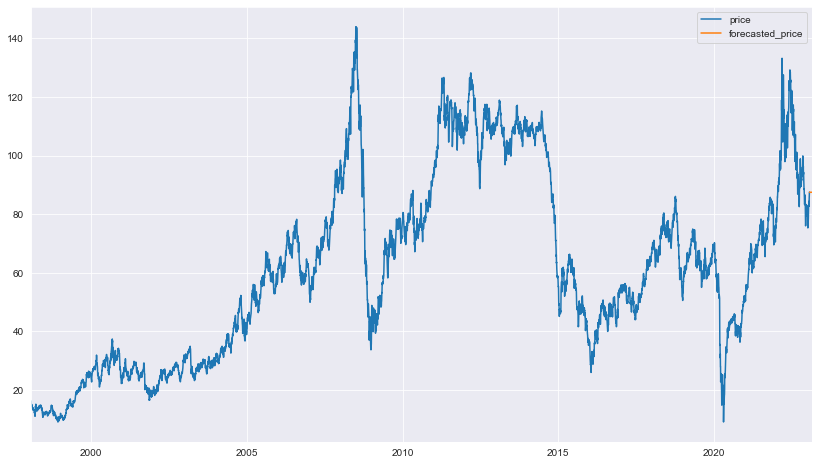

In [234]:
new_combine.plot(figsize=(14,8))

### Step-7 : Deployment of the model

#### Saving the model

In [235]:
import pickle 
pickle_out = open("G5_P192_Oil_price.pkl", mode = "wb") 
pickle.dump(final_model, pickle_out) 
pickle_out.close()

#### Deployment using Streamlit

In [5]:
%%writefile G5_P192_Oil_price.py
 
import pickle
import datetime
import streamlit as st
 
# loading the trained model
pickle_in = open('G5_P192_Oil_price.pkl', 'rb') 
regressor = pickle.load(pickle_in)

@st.cache()
# defining the function which will make the prediction using the data which the user inputs 
def prediction(date_op):   
       
    # Making predictions 
    pred = regressor.predict(date_op)
    return pred


# this is the main function in which we define our webpage  
def main():        
    # front end elements of the web page 
    html_temp = """ 
    <div style ="background-color:black;padding:13px"> 
    <h1 style ="color:red;text-align:center;">G5-P192 Oil Price Prediction</h1> 
    </div> 
    """
      
    # display the front end aspect
    st.markdown(html_temp, unsafe_allow_html = True) 
    from PIL import Image
    image = Image.open('Oil_price.jpg')
    st.image(image, use_column_width=True)
    import numpy as np  
    # following lines create boxes in which user can enter data required to make prediction 
    
    date_op = st.date_input(
    "**Please enter the date on which you want to know the oil price**",
    )
      
    # when 'Predict' is clicked, make the prediction and store it 
    if st.button("Forecast"): 
        result = prediction(date_op)
        final_result=result[0]
        st.write('**The Oil price is $**',np.round(final_result,4))
        st.balloons()
        print(final_result)
     
if __name__=='__main__': 
    main()

Overwriting G5_P192_Oil_price.py
